In [1]:
import os 
import matplotlib.pyplot as plt
import numpy as np
import random

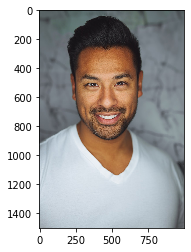

In [2]:
path = r'C:\Users\icecube\Documents\pythondata'
os.chdir(path)
img = plt.imread('face00.jfif')
plt.imshow(img)

In [3]:
#Best = find random window sampling scheme

# w = 1 samples: skin
train_10 = img[350:450,400:500]
train_11 = img[900:1000,400:500]
no_x1 = train_10.shape[0]*train_10.shape[1] + train_11.shape[0]*train_11.shape[1]
# w = 0 samples: no skin
train_00 = img[0:200,400:600]
train_01 = img[0:200,-200:]
no_x0 = train_00.shape[0]*train_00.shape[1] + train_01.shape[0]*train_01.shape[1]

In [4]:
# RGB image: will need to manipulate along channel values
def to_RGB(arr):
    R,G,B = arr[:,:,0],arr[:,:,1],arr[:,:,2]
    return R,G,B

w_10 = to_RGB(train_10)
w_11 = to_RGB(train_11)
w_00 = to_RGB(train_00)
w_01 = to_RGB(train_01)

# Later functions currently only work for two patches at a time
def pairing(w_i,w_j):
    elems = [*(w_i,w_j)]
    #e = [j for j in i for i in elems]
    e = []
    for i in elems:
        for j in i:
            e.append(j)
    return [(elem,n) for n,elem in zip(e[int(len(e)/2):],e[:int(len(e)/2)])]

In [5]:
# Estimating param in Norm_x(mu_w,var_w) in w={0,1}

paired_w1 = pairing(w_10,w_11)
paired_w0 = pairing(w_00,w_01)

def mu_est(data_w,x_tot):
    R,G,B = data_w
    return np.sum(np.add(*R))/x_tot,np.sum(np.add(*G))/x_tot,np.sum(np.add(*B))/x_tot

mu_est_1 = mu_est(paired_w1,no_x1)
mu_est_0 = mu_est(paired_w0,no_x0)

def var_w(data_w,mu,N):
    R,G,B = data_w  
    R_add,G_add,B_add = np.add(*R),np.add(*G),np.add(*B)
    channels = [R_add,G_add,B_add]
    var_x = []
    for i in range(len(channels)):
        arr = (channels[i]-mu[i])**2
        var_x.append(np.sum(arr)/N)
    #var = sum(var_x)
    return var_x

var_est_1 = var_w(paired_w1,mu_est_1,no_x1) 
var_est_0 = var_w(paired_w0,mu_est_0,no_x0) 

In [6]:
# Parameter estimation results on train data patches
print(mu_est_1, var_est_1)
print(mu_est_0, var_est_0)

(65.10145, 28.97375, 86.99095) [2227.75996184625, 4146.527866406251, 3927.64317714625]
(73.626225, 79.0991, 82.5145875) [3084.033413374062, 3706.113468785, 3937.6776870572658]


In [7]:
# Testing on new image patches
# Image train patches are 100x100 (w1), 200x200 (w0)
img_pixels = [(x,y) for x in range(100,img.shape[0]-100) for y in range(100,img.shape[1]-100)]
startx0,starty0 = random.choice(img_pixels)
test_window = img[startx0:startx0+100,starty0:starty0+100]
no_test = test_window.shape[0]*test_window.shape[1]

In [8]:
# Starting the inference part:
# P(x|w)
# sig_k is sigma_squared_k
def Norm(x,mu_k,sig_k):
    channels = R,G,B = to_RGB(x)
    norm = []
    for i in range(len(channels)):
        arr = (1/(2*np.pi*sig_k[i])**0.5)*np.exp(-0.5*(channels[i]-mu_k[i])**2/sig_k[i])
        norm.append(arr)
    return np.array(norm)

# P(w) for above image, based on hand-segmentation results
P_w1 = 0.2107
P_w0 = 0.7893

In [9]:
# Inference
# Would be better to eventually vectorize
norm_1 = Norm(test_window,mu_est_1,var_est_1)
norm_0 = Norm(test_window,mu_est_0,var_est_0)

num_1 = norm_1*P_w1
num_0 = norm_0*P_w0
denom = (norm_1*P_w1+norm_0*P_w0)

def posterior_calc(num,denom):
    return num.flatten()/denom.flatten()

post_1 = posterior_calc(num_1,denom).reshape(3,100,100)
post_0 = posterior_calc(num_0,denom).reshape(3,100,100)
post = [post_0,post_1]

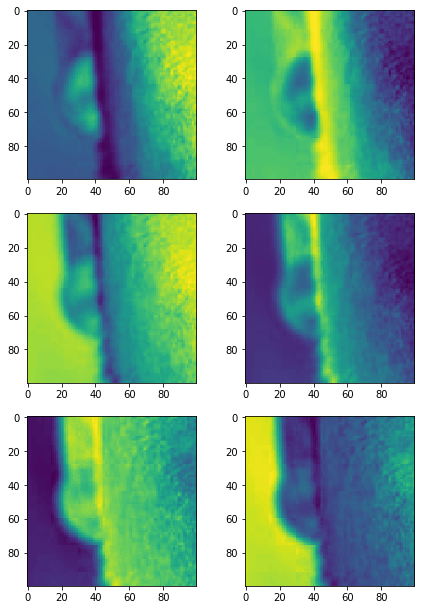

In [34]:
# Plotting probability map on all three channels for w={0,1}
fig,ax = plt.subplots(3,2,figsize=(10,10))
for i in range(3):
    for j in range(2):
        im = ax[i,j].imshow(post[j][i])
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.7,
                    wspace=0.02, hspace=0.2)
plt.show()

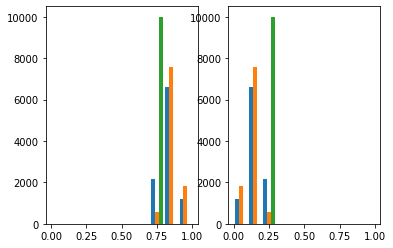

In [36]:
R_0,G_0,B_0 = post_0
post_hist_0 = [R_0.flatten(),G_0.flatten(),B_0.flatten()] 
R_1,G_1,B_1 = post_1
post_hist_1 = [R_1.flatten(),G_1.flatten(),B_1.flatten()]
post_list = [post_hist_0,post_hist_1]
fig,ax = plt.subplots(1,2)
for i in range(2):
    ax[i].hist(post_list[i],bins=10,range=(0,1.0))

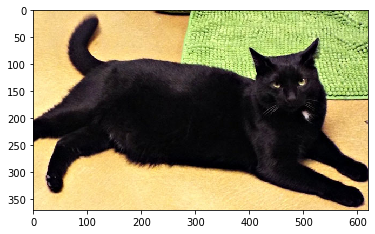

In [90]:
# Trying on picture with (more) homogeneous background
im_2 = plt.imread('black_cat.jpg')
plt.imshow(im_2)

In [91]:
# w = 1
train_10 = im_2[150:200,150:200]
train_11 = im_2[150:200,450:500]
no_x1 = train_10.shape[0]*train_10.shape[1] + train_11.shape[0]*train_11.shape[1]
# w = 0
train_00 = im_2[:50,:50] 
train_01 = im_2[:50,400:450]
no_x0 = train_00.shape[0]*train_00.shape[1] + train_01.shape[0]*train_01.shape[1]

In [92]:
w_10 = to_RGB(train_10)
w_11 = to_RGB(train_11)
w_00 = to_RGB(train_00)
w_01 = to_RGB(train_01)

In [93]:
paired_w1 = pairing(w_10,w_11)
paired_w0 = pairing(w_00,w_01)

mu_est_1 = mu_est(paired_w1,no_x1)
mu_est_0 = mu_est(paired_w0,no_x0)

var_est_1 = var_w(paired_w1,mu_est_1,no_x1) 
var_est_0 = var_w(paired_w0,mu_est_0,no_x0) 

print(mu_est_1, var_est_1)
print(mu_est_0, var_est_0)

(15.2946, 13.1222, 15.863) [325.18981626, 233.16040074, 306.7932465]
(89.7998, 87.2088, 44.3218) [4401.57767994, 4144.9250038400005, 5879.46166714]


In [99]:
img_pixels = [(x,y) for x in range(100,im_2.shape[0]-100) for y in range(100,im_2.shape[1]-100)]
startx0,starty0 = random.choice(img_pixels)
print(startx0,starty0)
test_window = im_2[startx0:startx0+100,starty0:starty0+100]
no_test = test_window.shape[0]*test_window.shape[1]

114 468


In [96]:
P_w0 = 0.4827157802964255
P_w1 = 1-P_w0

In [100]:
norm_1 = Norm(test_window,mu_est_1,var_est_1)
norm_0 = Norm(test_window,mu_est_0,var_est_0)

num_1 = norm_1*P_w1
num_0 = norm_0*P_w0
denom = (norm_1*P_w1+norm_0*P_w0)

def posterior_calc(num,denom):
    return num.flatten()/denom.flatten()

post_1 = posterior_calc(num_1,denom).reshape(3,100,100)
post_0 = posterior_calc(num_0,denom).reshape(3,100,100)
post = [post_0,post_1]

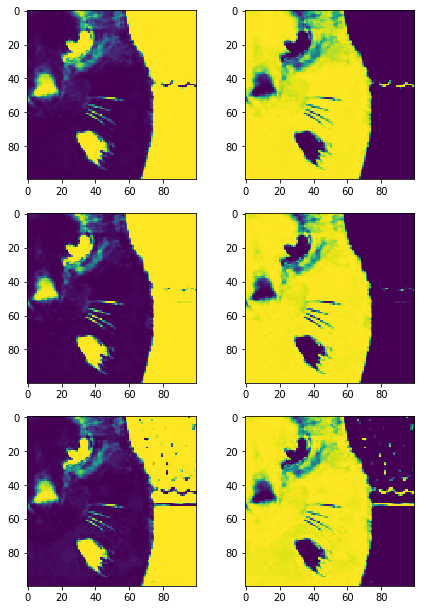

In [101]:
# Works
fig,ax = plt.subplots(3,2,figsize=(10,10))
for i in range(3):
    for j in range(2):
        im = ax[i,j].imshow(post[j][i])
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.7,
                    wspace=0.02, hspace=0.2)
plt.show()